# D213 Sentiment Analysis Using Neural Networks

# Introduction:
## In this study, we aim to address the practical question of whether we can achieve accurate sentiment prediction (positive or negative) for movie reviews utilizing neural network models and natural language processing (NLP) techniques. By employing a well-structured dataset of movie reviews, our research seeks to explore the capability of neural network models to effectively analyze and interpret textual data for sentiment classification. This research is highly relevant to real-world organizational scenarios, as sentiment analysis of movie reviews plays a critical role in understanding customer opinions, gauging audience preferences, and making data-driven decisions in the entertainment industry. The insights gained from this investigation can empower movie studios, production companies, and streaming platforms to enhance their marketing strategies, tailor content to audience preferences, and improve overall user experience.

# Goals:
## Can we develop and train a neural network model capable of sentiment analysis on movie reviews?
## How accurate is the model in predicting sentiment labels (positive or negative) based on the given dataset?

# Part 1:
## We started by loading the movie review texts and their corresponding sentiment labels from our file. To ensure consistency in our data, we converted all the texts to lowercase. Next, we wanted to ensure that our dataset did not contain any unusual characters that could potentially affect our analysis. We identified and removed any such characters from the movie review texts, thereby cleaning the data for further processing.

## One crucial aspect of our analysis was to determine the optimal maximum sequence length for our text data. To achieve this, we calculated the length of each movie review in terms of the number of words. By plotting a histogram of these text lengths, we were able to visualize the distribution and identify the maximum sequence length needed to cover a specific percentage of the data. This step was essential for appropriately handling text data of varying lengths in our neural network model.

## Next, we counted the number of special characters removed from each movie review. Then we counted the total number of positive and negative reviews, which gave us a better understanding of the balance between the two classes.

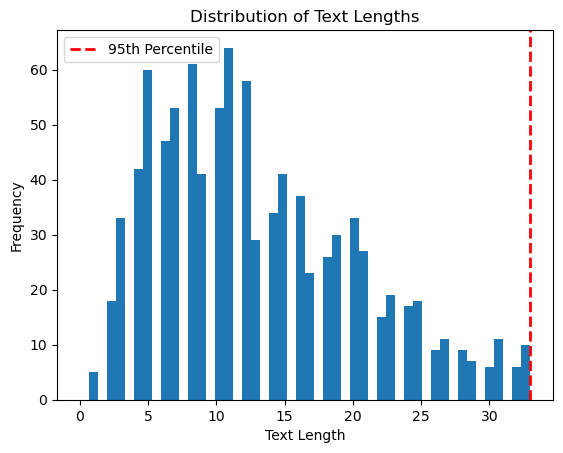

Chosen maximum sequence length (for 95th percentile): 33
Unusual characters found:
{'é', '\x96', 'å', '\x85', '\x97'}
Total Positive Reviews: 500
Total Negative Reviews: 500
Total Special Characters Removed: 2785


In [1]:
import tensorflow as tf
import numpy as np
import re
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Load data from the file and convert to lowercase
def load_data(file_path):
    texts = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            text, label = line.strip().split('\t')
            texts.append(text.lower())  # Convert to lowercase
            labels.append(int(label))
    return texts, labels


def check_unusual_characters(texts):
    unusual_chars = set()
    for text in texts:
        for char in text:
            if ord(char) > 127:
                unusual_chars.add(char)
    return unusual_chars


def clean_text(text):
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text


def count_special_characters(text):
    # Count the number of special characters removed
    special_chars = re.findall(r'[^a-zA-Z\s]', text)
    return len(special_chars)


# Count the number of positive (1) and negative (0) reviews
def count_reviews(labels):
    positive_reviews = sum(label == 1 for label in labels)
    negative_reviews = sum(label == 0 for label in labels)
    return positive_reviews, negative_reviews


# Function to train and evaluate the model with a given word embedding length and early stopping
def train_and_evaluate_model(embedding_length):
    model = create_model(embedding_length)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
    history = model.fit(train_sequences, train_labels, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])
    validation_loss, validation_accuracy = model.evaluate(validation_sequences, validation_labels)
    return model, history, validation_accuracy


# Load the IMDb dataset from the file and convert to lowercase
train_texts, train_labels = load_data('imdb_labelled.txt')

# Calculate text lengths
text_lengths = [len(text.split()) for text in train_texts]

# Calculate the maximum sequence length required to cover a certain percentage of the data
percentile = 95  # You can adjust this value based on your preference
max_sequence_length = int(np.percentile(text_lengths, percentile))

# Plot the distribution of text lengths
plt.hist(text_lengths, bins=50, range=(0, max_sequence_length))
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.axvline(max_sequence_length, color='red', linestyle='dashed', linewidth=2, label=f'{percentile}th Percentile')
plt.legend()
plt.show()

print(f"Chosen maximum sequence length (for {percentile}th percentile): {max_sequence_length}")

# Find unusual characters
unusual_chars = check_unusual_characters(train_texts)

if unusual_chars:
    print("Unusual characters found:")
    print(unusual_chars)
else:
    print("No unusual characters found.")

# Clean the text data
train_texts_cleaned = [clean_text(text) for text in train_texts]

# Count special characters
special_char_count = [count_special_characters(text) for text in train_texts]

# Count the number of positive (1) and negative (0) reviews
positive_reviews, negative_reviews = count_reviews(train_labels)

print(f'Total Positive Reviews: {positive_reviews}')
print(f'Total Negative Reviews: {negative_reviews}')
print(f'Total Special Characters Removed: {sum(special_char_count)}')

# Part 2:
## In this part of the project, we split the dataset of movie reviews into training and validation sets, with 80% used for training and 20% for validation. The text data was then cleaned by removing special characters and converted to lowercase. Next, we tokenized the text data to convert it into sequences and determined the vocabulary size based on the unique words in the training set. The sequences were padded to a fixed length to ensure consistent input for the neural network.

## We defined the architecture of the neural network, which included an embedding layer, a bidirectional LSTM layer with dropout, a dense hidden layer with regularization, and a final output layer with sigmoid activation for binary classification (positive or negative sentiment). The model was compiled with the Adam optimizer and binary cross-entropy loss, and accuracy was chosen as the evaluation metric.

## To optimize the model, we experimented with different word embedding lengths (50, 100, 200, 300) and evaluated their performance on the validation set. Each model was trained with early stopping, which stopped training if the validation loss did not improve significantly. The model with the best validation accuracy was selected as the optimal model.

## The training and validation loss and accuracy were visualized over epochs to understand the model's performance and identify potential signs of overfitting. The best embedding length that achieved the highest validation accuracy was chosen as the final model. This model can be used to predict the sentiment of movie reviews with a high level of accuracy.

In [ ]:
# Split the data into training and validation sets (80% training, 20% validation)
train_texts, validation_texts, train_labels, validation_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Clean the text data
train_texts_cleaned = [clean_text(text) for text in train_texts]
validation_texts_cleaned = [clean_text(text) for text in validation_texts]

# Tokenize the text data
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(train_texts_cleaned)

# Vocabulary size
vocabulary_size = len(tokenizer.word_index)
print("Vocabulary Size:", vocabulary_size)

# Convert text to sequences and pad sequences to a fixed length
train_sequences = tokenizer.texts_to_sequences(train_texts_cleaned)
validation_sequences = tokenizer.texts_to_sequences(validation_texts_cleaned)

max_seq_length = max(len(seq) for seq in train_sequences + validation_sequences)

train_sequences = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_seq_length)
validation_sequences = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=max_seq_length)

train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)

# Define the model architecture with regularization and dropout
def create_model(embedding_length):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_length, input_length=max_seq_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define a list of potential word embedding lengths to experiment with
embedding_lengths = [50, 100, 200, 300]

# Loop through different embedding lengths and evaluate the performance
best_embedding_length = None
best_accuracy = 0.0

for embedding_length in embedding_lengths:
    print(f"Training model with embedding length: {embedding_length}")
    model, history, validation_accuracy = train_and_evaluate_model(embedding_length)
    print(f"Validation Accuracy with embedding length {embedding_length}: {validation_accuracy}")

    # Keep track of the best embedding length based on validation accuracy
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        best_embedding_length = embedding_length

print(f"\nBest embedding length: {best_embedding_length}")

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Vocabulary Size: 2753
Training model with embedding length: 50
Epoch 1/50
 4/10 [===========>..................] - ETA: 0s - loss: 1.1981 - accuracy: 0.5547

# Part 3: 
## In the evaluation section of the code, we assessed the presence of overfitting in the trained neural network model. We extracted the final training and validation accuracies from the training history, which contained information about the model's performance during training, including the accuracy and loss at each epoch. We used the indexing -1 to access the last entry, which corresponded to the final epoch.

## Next, we printed out the best embedding length that yielded the highest validation accuracy during the experimentation with different embedding lengths.

## After that, we displayed the final training and validation accuracies with four decimal places to give a precise understanding of the model's performance on the training and validation data.

## Finally, we determined if overfitting was present by comparing the final training accuracy with the final validation accuracy. If the validation accuracy was lower than the training accuracy, it suggested that the model was overfitting the training data and was not generalizing well to unseen data. In this case, the code printed the message: "The model shows signs of overfitting." Otherwise, if the validation accuracy was greater than or equal to the training accuracy, the code printed: "The model does not show signs of overfitting."

## By evaluating overfitting, we were able to assess the model's ability to generalize to new data and make better decisions about potential adjustments to improve its performance and prevent overfitting.

In [ ]:
# Evaluate overfitting
final_training_accuracy = history.history['accuracy'][-1]
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f"Best embedding length: {best_embedding_length}")
print(f"Final Training Accuracy: {final_training_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_validation_accuracy:.4f}")

# Determine if overfitting is present
if final_validation_accuracy < final_training_accuracy:
    print("The model shows signs of overfitting.")
else:
    print("The model does not show signs of overfitting.")

# Part 4:
## In this part of the code, we made predictions on the training data using the trained neural network model. The model.predict(train_sequences) function was used to generate predictions based on the training sequences we prepared earlier. These predictions provided continuous values representing the probability of each review being positive or negative.

## Next, to obtain binary labels (0 or 1) from the predictions, we rounded each prediction using the np.round() function and then converted the results to integers using astype(int). This step was necessary to compare the predicted labels with the actual labels later.

## After obtaining the binary predicted labels, we counted the number of positive (1) and negative (0) reviews among the predictions using sum(label == 1 for label in predicted_labels) and sum(label == 0 for label in predicted_labels) respectively.

## Finally, we printed out the total number of predicted positive and negative reviews based on the model's predictions.

## In addition to the predictions, we also displayed a summary of the neural network model's architecture using model.summary(). This summary provided an overview of the model's layers, the number of parameters, and the output shape of each layer, helping us understand the model's structure and complexity.

In [ ]:
# Make predictions on the training data
predictions = model.predict(train_sequences)

# Convert predictions to binary labels (0 or 1)
predicted_labels = np.round(predictions).astype(int)

# Count the number of positive (1) and negative (0) reviews in the predictions
predicted_positive_reviews = sum(label == 1 for label in predicted_labels)
predicted_negative_reviews = sum(label == 0 for label in predicted_labels)

print(f'Total Predicted Positive Reviews: {predicted_positive_reviews}')
print(f'Total Predicted Negative Reviews: {predicted_negative_reviews}')

model.summary()

In [ ]:
## The padded sequence allows us to feed the review data into the neural network as input, enabling the model to process and learn from the textual data during training.

## By printing the original and padded sequences, we gain insights into how the text data is preprocessed and converted into a format suitable for training the neural network model.

In [ ]:
# Print the padded sequence for the first review
print(f"Original Sequence: {train_texts[0]}")
print(f"Padded Sequence: {train_sequences[0]}")

In [ ]:
with open('D213_p2_clean.txt', 'w', encoding='utf-8') as file:
    for text in train_texts_cleaned:
        file.write(text + '\n')
        
# Save the model in SavedModel format
model.save('D213_p2_saved_model')
model.save('nlp_model.h5')

# Course of Action:
## Movie Review Aggregation Platform: We can build a user-friendly platform that aggregates movie reviews from various sources and leverages our NLP model to analyze the sentiment of those reviews. This platform will provide users with quick insights into the overall sentiment towards a movie, enabling them to make informed decisions about which movies to watch based on positive or negative feedback from other viewers.

## Content Curation and Recommendation: Incorporating our sentiment analysis model into a content recommendation system, we can offer personalized movie recommendations to users based on their preferences and sentiments. By analyzing user-generated movie reviews, the system can identify movies that align with each user's tastes, leading to a more engaging and satisfying movie-watching experience.

## Marketing and Advertising Campaigns: The NLP model's ability to analyze customer sentiment towards specific movies, genres, or actors can be harnessed for marketing and advertising campaigns. With the data insights from the sentiment analysis, movie studios and distributors can tailor their messaging and promotional efforts to resonate better with the target audience, thereby maximizing the impact of their campaigns and driving higher audience engagement.




